# Final Project Code: Genre Classification 

Datasets can be found in /datasets folder

### Step #1: Mount Google Drive and download libraries

a. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


b. Import Libraries: 

In [ ]:
import re
import pandas as pd
import nltk
import gensim

from sklearn.datasets import fetch_openml as fetch_mldata
from sklearn.model_selection import cross_val_score

from numpy import mean
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from gensim.models import Word2Vec
bigmodel = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/bigmodel/GoogleNews-vectors-negative300-SLIM.bin", binary=True)
# bigmodel = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/2022-2023/CSCI3349 Natural Language Processing/Final Project/Datasets/GoogleNews-vectors-negative300-SLIM.bin", binary=True)

Access Information about our dataset here: 
--> Spotify: 
--> Genre Classification 


In [ ]:
genreData =  fetch_mldata(name='Music-Dataset--1950-to-2019', version=1)
gdf = genreData.data
x = gdf["lyrics"]
y = gdf["genre"]
print(y[1])
print(x[1])   

In [ ]:
spotifyData = fetch_mldata(name='150K-Lyrics-Labeled-with-Spotify-Valence', version=1)
sdf = spotifyData.data
spotify_x = sdf["seq"]
spotify_y = sdf["label"]
print(spotify_x[1])
print(spotify_y[1])   

### Step #2: Tokenize Lyrics for both datasets


In [ ]:
nltk.download('punkt');
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]   

In [ ]:
gdf['lyrics_tokenized'] = gdf.apply(lambda x: tokenize(x['lyrics']), axis=1)
gdf[['lyrics_tokenized']].head() 

sdf['lyrics_tokenized'] = sdf.apply(lambda x: tokenize(x['seq']), axis=1)
sdf[['lyrics_tokenized']].head()  


NameError: ignored

### Spotify data: Bin Valences (for baselines data) in spotify valence data

USE sdf['Valence'] FOR OUTPUTS

--> 0 - 0.2 : Very Negative  

--> 0.2 - 0.4: Somewhat Negative 

--> 0.4 - 0.6: Neutral 

--> 0.6 - 0.8: Somewhat Positive 

--> 0.8 - 1.0 : Very Postive 

In [ ]:
# print(sdf.shape)  
valence = [] 
count = len(sdf) 
vn = 0 
sn = 0 
n = 0 
sp = 0 
vp = 0 
# Bin valences 
for val in spotify_y: 
  if val < 0.2: 
    valence.append('Very Negative')
    vn +=1
  elif val >= 0.2 and val < 0.4: 
    valence.append('Somewhat Negative')
    sn +=1
  elif val >= 0.4 and val < 0.6: 
    valence.append('Neutral')
    n +=1
  elif val >= 0.6 and val < 0.8:
    valence.append('Somewhat Positive')
    sp +=1
  elif val >= 0.8: 
    valence.append('Very Positive')
    vp +=1
sdf['valence'] = valence 
print('---------------------TRAINING SET VALENCE BASELINE DATA------------------')
print('Very negative songs: ', vn/count)
print('Somewhat negative songs: ', sn/count)
print('Neutral songs: ', n/count)
print('Somewhat positive songs: ', sp/count)
print('Very positive songs: ', vp/count)

---------------------TRAINING SET VALENCE BASELINE DATA------------------
Very negative songs:  0.14866784967761898
Somewhat negative songs:  0.25023207643682155
Neutral songs:  0.2464367583815905
Somewhat positive songs:  0.21503223810095168
Very positive songs:  0.1396310774030173


### Delete 'pop' genre, because many of the songs are overrepresented as pop songs

In [ ]:
gdf.drop(gdf.loc[gdf['genre'] == 'pop'].index, inplace=True)
print(gdf.shape)

(21330, 32)


###Step #3: Split Training and Testing Data and reassign x and y values

Adapted from this source: https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830


*   x1 --> lyrics for spotify valence, training data
*   y1 --> valence for training data 
*   x1test --> " ", testing data 
* y1test --> " ", testing data 
* x2 --> lyrics for genre dataset, training data 
* y2 --> genre for trainng data
* x2test --> " ", testing data 
* x2test --> " ", testing data

In [ ]:
g_unsplit_data = gdf['lyrics_tokenized']
g_unsplit_targets = gdf['genre']

print(g_unsplit_data.shape)
print(g_unsplit_targets.shape)

(21330,)
(21330,)


In [ ]:
from matplotlib.pyplot import scatter, xlabel, ylabel, show
from numpy import unique

In [ ]:
def plotData(data, targets, labelX='', labelY=''):
    colors = ['r','g','b','m','c','k','y']
    for i in range(len(unique(targets))):
        scatter(data[targets==i,0], data[targets==i,1], c=colors[i%len(colors)])
    xlabel(labelX, fontsize=16);
    ylabel(labelY, fontsize=16);
    show()


In [ ]:
## We are using a 80/20 split 
spotify_training_data = sdf.sample(frac=0.8, random_state=25)
spotify_testing_data = sdf.drop(spotify_training_data.index)

print(f"No. of spotify training examples: {spotify_training_data.shape[0]}")
print(f"No. of spotify testing examples: {spotify_testing_data.shape[0]}") 

genre_training_data = gdf.sample(frac=0.8, random_state=25)
genre_testing_data = gdf.drop(genre_training_data.index)

print(f"No. of genre training examples: {genre_training_data.shape[0]}")
print(f"No. of genre testing examples: {genre_testing_data.shape[0]}")  

x1 = spotify_training_data['lyrics_tokenized']  
y1 = spotify_training_data['valence'] 

x1test = spotify_testing_data['lyrics_tokenized']
y1test = spotify_testing_data['valence']

print(x1.shape, y1.shape)
print(x1test.shape, y1test.shape)

x2 = genre_training_data['lyrics_tokenized']
y2 = genre_training_data['genre']
x2test = genre_testing_data['lyrics_tokenized']
y2test = genre_testing_data['genre']

print(x2.shape, y2.shape)
print(x2test.shape, y2test.shape)

No. of spotify training examples: 126682
No. of spotify testing examples: 31671
No. of genre training examples: 17064
No. of genre testing examples: 4266
(126682,) (126682,)
(31671,) (31671,)
(17064,) (17064,)
(4266,) (4266,)


### Step 4: Baselines for Music Genre Data 

Calculate how many songs fall into each genre category  
Genres include: pop, rock, country, blues, jazz, hip hop, and reggae

Should we drop pop songs? They are the majority amount of songs, so we may have an unbalanced dataset...

In [ ]:
## Baselines for genre data 
count = len(gdf)
# 7 genres 
print(gdf['genre'].unique())
popcount = 0
rockcount = 0
countrycount = 0
bluescount = 0 
jazzcount = 0 
hhcount = 0 
regcount = 0 

for genre in y: 
  if genre == 'pop': 
    popcount += 1 
  elif genre == 'rock': 
    rockcount += 1 
  elif genre == 'country': 
    countrycount += 1
  elif genre == 'blues': 
    bluescount += 1 
  elif genre == 'jazz': 
    jazzcount += 1 
  elif genre == 'reggae': 
    regcount += 1 
  elif genre == 'hip hop': 
    hhcount += 1
print('---------------------GENRE BASELINE DATA------------------')
print('Percentage of pop songs', popcount/count)
print('Percentage of blues songs', bluescount/count)
print('Percentage of rock songs', rockcount/count)
print('Percentage of country songs', countrycount/count)
print('Percentage of jazz songs', jazzcount/count)
print('Percentage of reggae songs', regcount/count)
print('Percentage of hip hop songs', hhcount/count)

['country' 'blues' 'jazz' 'reggae' 'rock' 'hip hop']
---------------------GENRE BASELINE DATA------------------
Percentage of pop songs 0.3301453352086263
Percentage of blues songs 0.21584622597280825
Percentage of rock songs 0.18912330051570558
Percentage of country songs 0.2552742616033755
Percentage of jazz songs 0.1802625410220347
Percentage of reggae songs 0.11711204875761838
Percentage of hip hop songs 0.04238162212845757


## Step 5: Genre Classification 

*   Use wordtovec to create a term-document matrix for each song 



In [ ]:
# TRAINING DATA 
genretargets = []
genrevectors = []
for genre in y2: 
  if genre == 'rock': 
    genretargets.append(1)
  elif genre == 'country': 
    genretargets.append(2)
  elif genre == 'blues': 
    genretargets.append(3)
  elif genre == 'jazz': 
    genretargets.append(4)
  elif genre == 'reggae': 
    genretargets.append(5) 
  elif genre == 'hip hop': 
    genretargets.append(6)
for h in x2:
    totvec = np.zeros(300)
    for w in h:
        if w.lower() in bigmodel:
            totvec = totvec + bigmodel[w.lower()]
    genrevectors.append(totvec)

# TESTING DATA 
gtesttargets = []
gtestvectors = []
for genre in y2test: 
  if genre == 'rock': 
    gtesttargets.append(1)
  elif genre == 'country': 
    gtesttargets.append(2)
  elif genre == 'blues': 
    gtesttargets.append(3)
  elif genre == 'jazz': 
    gtesttargets.append(4)
  elif genre == 'reggae': 
    gtesttargets.append(5) 
  elif genre == 'hip hop': 
    gtesttargets.append(6)
for h in x2test:
    totvec = np.zeros(300)
    for w in h:
        if w.lower() in bigmodel:
            totvec = totvec + bigmodel[w.lower()]
    gtestvectors.append(totvec)


Unsplit Data Used for 5-fold Cross-validation (80-20 split)

In [ ]:
# UNSPLIT DATA
unsplitData = []
unsplitTarget = []

for genre in y2test: 
  if genre == 'rock': 
    unsplitTarget.append(1)
  elif genre == 'country': 
    unsplitTarget.append(2)
  elif genre == 'blues': 
    unsplitTarget.append(3)
  elif genre == 'jazz': 
    unsplitTarget.append(4)
  elif genre == 'reggae': 
    unsplitTarget.append(5) 
  elif genre == 'hip hop': 
    unsplitTarget.append(6)
for h in x2test:
    totvec = np.zeros(300)
    for w in h:
        if w.lower() in bigmodel:
            totvec = totvec + bigmodel[w.lower()]
    unsplitData.append(totvec)

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

(4266, 3)


Text(0.5, 0, 'Z Label')

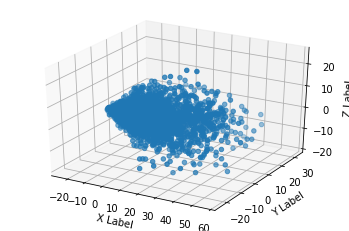

In [ ]:
pca = PCA(n_components=3)
pca.fit(unsplitData)
x = pca.transform(unsplitData)
print(x.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = [i[0] for i in x]
ys = [i[1] for i in x]
zs = [i[2] for i in x]

ax.scatter(xs, ys, zs)



ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


In [ ]:
'''model = GaussianNB()
model.fit(genrevectors, alltargets)

expected = testtargets
predicted = model.predict(testvectors)
print(metrics.classification_report(expected, predicted))'''


'''model2 = LinearSVC()
model2.max_iter = 100000
model2.fit(genrevectors, alltargets)

expected2 = testtargets
predicted2 = model2.predict(testvectors)
print(metrics.classification_report(expected2, predicted2))'''


'''model3 = LogisticRegression()
model3.max_iter = 100000
model3.fit(genrevectors, alltargets)

expected3 = testtargets
predicted3 = model3.predict(testvectors)
print(metrics.classification_report(expected3, predicted3))'''


# gmodel4 = MLPClassifier()
# gmodel4.fit(genrevectors, genretargets)

# gexpected4 = gtesttargets
# gpredicted4 = gmodel4.predict(gtestvectors)
# print(metrics.classification_report(gexpected4, gpredicted4))


'''model5 = KNeighborsClassifier()
model5.fit(genrevectors, alltargets)

expected5 = testtargets
predicted5 = model5.predict(testvectors)
print(metrics.classification_report(expected5, predicted5))'''


accuracy:  0.3492875284493848


Trying KNN Classifier with different K values

1 0.6840131295793719
5 0.6594586281197092
10 0.6552979453431109
20 0.6525436155599805
30 0.6512546676059985
40 0.6448082103837853
50 0.645863086763286
60 0.6466836339504598
70 0.6485000973795456
80 0.6479726334280107
100 0.6513712654429018


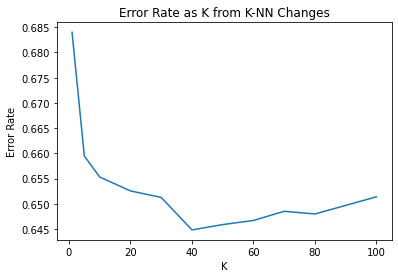

In [ ]:
k = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100]
errors = []
for i in k:
    classifer = KNeighborsClassifier(n_neighbors=i)
    classifer.fit(genrevectors, genretargets)
    acc = mean(cross_val_score(classifer, genrevectors, genretargets, cv=5))
    err = 1 - acc
    errors.append(err)
    print(i, err)
plt.plot(k, errors)

plt.title("Error Rate as K from K-NN Changes")
plt.xlabel("K")
plt.ylabel("Error Rate")

plt.show()

Neural Net with Layer and 10-fold Cross Validation

In [ ]:
net = MLPClassifier(hidden_layer_sizes=(100,50,25))
net.fit(unsplitData, unsplitTarget)
acc = mean(cross_val_score(net, unsplitData, unsplitTarget, cv=5))
print("accuracy: ", acc)

accuracy:  0.3366171468106779


Logistic Regression trying Different regularization parameters

C:  0.001 accuracy:  0.3560775991060618
C:  0.01 accuracy:  0.3652187759965516
C:  0.1 accuracy:  0.35888598169842767
C:  1 accuracy:  0.3502120906787176
C:  10 accuracy:  0.3413040076215369
C:  100 accuracy:  0.34247551691097133
C:  1000 accuracy:  0.3415376505569268
C:  10000 accuracy:  0.3417721171454379
C:  100000 accuracy:  0.3417721171454379
C:  1000000 accuracy:  0.34130345851945604


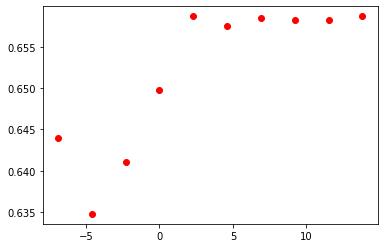

In [ ]:
p = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
c = [10 ** i for i in p]
for i in c:
    classifer = LogisticRegression(C = i, max_iter=50000)
    # classifer.fit(x, y)
    acc = mean(cross_val_score(classifer, unsplitData, unsplitTarget))
    print("C: ", i , "accuracy: ", acc)
    err = 1 - acc
    plt.plot(np.log(i), err,'ro')
plt.show()

Spotify Valence Classifiers

In [ ]:
#Training data
spotifytargets = []
spotifyvectors = []
for label in y1:#spotify_testing_data['label']: 
  if label == 'Very Negative':
    spotifytargets.append(0)
  elif label == 'Somewhat Negative':
    spotifytargets.append(1)
  elif label == 'Neutral':   
    spotifytargets.append(2)
  elif label == 'Somewhat Positive':
    spotifytargets.append(3)
  elif label == 'Very Positive': 
    spotifytargets.append(4)
for h in x1:
    totvec = np.zeros(300)
    for w in h:
        if w.lower() in bigmodel:
            totvec = totvec + bigmodel[w.lower()]
    spotifyvectors.append(totvec)

#Testing data
stesttargets = []
stestvectors = []
for label in y1test: 
  if label == 'Very Negative': 
    stesttargets.append(0)
  elif label == 'Somewhat Negative': 
    stesttargets.append(1)
  elif label == 'Neutral':  
    stesttargets.append(2)
  elif label == 'Somewhat Positive': 
    stesttargets.append(3)
  elif label == 'Very Positive': 
    stesttargets.append(4)
for h in x1test:
    totvec = np.zeros(300)
    for w in h:
        if w.lower() in bigmodel:
            totvec = totvec + bigmodel[w.lower()]
    stestvectors.append(totvec)


In [ ]:
'''model = GaussianNB()
model.fit(spotifyvectors, alltargets)

expected = testtargets
predicted = model.predict(testvectors)
print(metrics.classification_report(expected, predicted))'''


'''model2 = LinearSVC()
model2.max_iter = 100000
model2.fit(spotifyvectors, alltargets)

expected2 = testtargets
predicted2 = model2.predict(testvectors)
print(metrics.classification_report(expected2, predicted2))'''


'''model3 = LogisticRegression()
model3.max_iter = 100000
model3.fit(spotifyvectors, alltargets)

expected3 = testtargets
predicted3 = model3.predict(testvectors)
print(metrics.classification_report(expected3, predicted3))'''


model4 = MLPClassifier()
model4.max_iter = 100000
model4.fit(spotifyvectors, spotifytargets)

expected4 = stesttargets
predicted4 = model4.predict(stestvectors)
print(metrics.classification_report(expected4, predicted4))


'''model5 = KNeighborsClassifier()
model5.max_iter = 100000
model5.fit(spotifyvectors, alltargets)

expected5 = testtargets
predicted5 = model5.predict(testvectors)
print(metrics.classification_report(expected5, predicted5))'''

Find a Trend

In [ ]:
predictedtrend1 = gmodel4.predict(stestvectors)
predictedtrend2 = model4.predict(stestvectors)

rocklist = []
countrylist = []
blueslist = []
jazzlist = []
reggaelist = []
hiphoplist = []
for i in range(len(predictedtrend1)):
  if predictedtrend1[i] == 1:
    rocklist.append(predictedtrend2[i])
  if predictedtrend1[i] == 2:
    countrylist.append(predictedtrend2[i])
  if predictedtrend1[i] == 3:
    blueslist.append(predictedtrend2[i])
  if predictedtrend1[i] == 4:
    jazzlist.append(predictedtrend2[i])
  if predictedtrend1[i] == 5:
    reggaelist.append(predictedtrend2[i])
  if predictedtrend1[i] == 6:
    hiphoplist.append(predictedtrend2[i])

biglist = []
biglist.extend([rocklist, countrylist, blueslist, jazzlist, reggaelist, hiphoplist])

label = ""
current = 0
for item in biglist:
  counter0,counter1,counter2,counter3,counter4 = 0,0,0,0,0 
  for i in item:
    if i==0:
      counter0 += 1
    if i==1:
      counter1 += 1
    if i==2:
      counter2 += 1
    if i==3:
      counter3 += 1
    if i==4:
      counter4 += 1
  if current == 0:
    label = "Rock"
  if current == 1:
    label = "Country"
  if current == 2:
    label = "Blues"
  if current == 3:
    label = "Jazz"
  if current == 4:
    label = "Reggae"
  if current == 5:
    label = "HipHop"

  print(label, "is ", counter0/len(item), "% Very Negative")
  print(label, "is ", counter1/len(item), "% Somewhat Negative")
  print(label, "is ", counter2/len(item), "% Neutral")
  print(label, "is ", counter3/len(item), "% Somewhat Positive")
  print(label, "is ", counter4/len(item), "% Very Positve")
  current +=1

### Fitting Lyric Data for Spotify Valence and Genre Classification with DistilBert

https://www.kaggle.com/code/jmourad100/news-classification-arabert

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
import torch
from tensorflow.python.keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils 

In [ ]:
# # Encode labels for genre and valence 
# encoder = LabelEncoder()
# encoder.fit(sdf['valence'])
# sdf['valence'] = encoder.transform(sdf['valence']) 
# # print(spotify_training_data.head())
# # encoder.fit(sdf['valence'])
# spotify = pd.DataFrame().assign(seq=sdf['seq'], valence=sdf['valence'])
# print(spotify.head())
# spotify = spotify.sample(n=3600, random_state=1)
# print(spotify.shape)

# # encoder.fit(genre_training_data['genre']) 
# # gdf['genre'] = encoder.transform(gdf['genre'])
# # print(genre_training_data.head())
# encoder.fit(gdf['genre']) 
# gdf['genre'] = encoder.transform(gdf['genre'])
# genre = pd.DataFrame().assign(lyrics=gdf['lyrics'], genre=gdf['genre'])
# print(genre.head())

# #  SPOTIFY BERT 
# train_texts, val_texts, train_labels, val_labels = train_test_split(spotify["seq"], spotify["valence"], test_size=.2)
# # GENRE BERT 
# # small_train_dataset_g = genre_training_data.sample(n=3000)
# # small_train_dataset_g = genre_testing_data.sample(n=300)


Tokenize Lyric Data

In [ ]:
# # lyrics_train = small_train_dataset.seq.values 
# # # print(lyrics_train[0])
# # lyrics_test = small_test_dataset.seq.values
# # MAX_LEN = 512
# # train_texts = train_texts.apply(lambda x:  str(x[0], 'utf-8'))

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case =True) 
# train_encodings = tokenizer(list(train_texts.values), truncation=True, padding=True, max_length = 512)
# val_encodings = tokenizer(list(val_texts.values), truncation=True, padding=True,  max_length = 512)
# # test_encodings = tokenizer(list(test_texts).values, truncation=True, padding=True)

# # tokenized_small_train = [tokenizer(lyric, add_special_tokens=True,truncation = True, max_length=MAX_LEN,pad_to_max_length=True) for lyric in lyrics_train]
# # tokenized_small_test = [tokenizer(lyric, add_special_tokens=True,truncation = True, max_length=MAX_LEN,pad_to_max_length=True) for lyric in lyrics_test]
# # # labels = spotify_testing_data['valence']

In [ ]:
# import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),list(train_labels.values)))
# test_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_labels.values)))

In [ ]:
# print(train_encodings['input_ids'][0])
# print(train_encodings['attention_mask'][0])

In [ ]:
# from transformers import DataCollatorWithPadding
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# from transformers import TrainingArguments, Trainer

# model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

In [ ]:
# import numpy as np
# from datasets import load_metric
 
# def compute_metrics(eval_pred):
#    load_accuracy = load_metric("accuracy")
#    load_f1 = load_metric("f1")
  
#    logits, labels = eval_pred
#    predictions = np.argmax(logits, axis=-1)
#    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
#    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
#    return {"accuracy": accuracy, "f1": f1}

In [ ]:
# training_args = TrainingArguments(
#     output_dir="/content/drive/MyDrive/results",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=5,
#     weight_decay=0.01,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset= train_dataset,
#     eval_dataset= test_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     # compute_metrics=compute_metrics
# )

In [ ]:
# trainer.train()

In [ ]:
# trainer.evaluate()

In [ ]:
# from transformers import TFDistilBertModel
# model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# #chose the optimizer
# optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
# #define the loss function 
# #build the model
# model.compile(optimizer=optimizerr,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# # train the model 
# model.fit(train_encodings,
#           epochs=3,
#           batch_size=16)

TEST FOR BERT

In [ ]:
from datasets import Dataset
import pandas as pd
from datasets import load_dataset

strdata = []
streata = []
for label in y1:#spotify_testing_data['label']: 
  if label == 'Very Negative':
    strdata.append(0)
  elif label == 'Somewhat Negative':
    strdata.append(1)
  elif label == 'Neutral':   
    strdata.append(2)
  elif label == 'Somewhat Positive':
    strdata.append(3)
  elif label == 'Very Positive': 
    strdata.append(4)

for label in y1test: 
  if label == 'Very Negative': 
    streata.append(0)
  elif label == 'Somewhat Negative': 
    streata.append(1)
  elif label == 'Neutral':  
    streata.append(2)
  elif label == 'Somewhat Positive': 
    streata.append(3)
  elif label == 'Very Positive': 
    streata.append(4)
  
#df = pd.DataFrame({"lyrics_tokenized": spotify_training_data["seq"], "valence":spotify_training_data["label"]})
#df2 = pd.DataFrame({"lyrics_tokenized": spotify_testing_data["seq"], "valence":spotify_testing_data["label"]})

df = pd.DataFrame({"text": spotify_training_data["seq"], "label":strdata})
df2 = pd.DataFrame({"text": spotify_testing_data["seq"], "label":streata})

df.to_csv(r'/content/drive/MyDrive/train.csv',index=False)
df2.to_csv(r'/content/drive/MyDrive/test.csv',index=False)

print(df.head())
dataset = load_dataset('csv',data_files={'train': '/content/drive/MyDrive/train.csv', 
                                           'test': '/content/drive/MyDrive/test.csv'})



                                                     text  label
75388   Hey, Bungalow Bill\nWhat did you kill\nBungalo...      2
23762   Uncertainty follows me like a shade and it fog...      3
85212   [Dialogue borrowed from a "Rocky" movie]\nThis...      1
44119   This is the death\nThe death of rock\nYou may ...      1
143317  Welcome to the system\nHere's the situation\nI...      2


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2d33e905ac60e4e7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: A100-SXM4-40GB


In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = dataset["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", num_labels = 5)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_small_train = small_train_dataset.map(preprocess_function)
tokenized_small_test = small_test_dataset.map(preprocess_function)

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/300 [00:00<?, ?ex/s]

In [ ]:
print(tokenized_small_train[0])

{'text': "Put your swords away I'm already down\nThe higher we both climb the further we fall\nNow were under looking up into the floor\nAnd burn each other though we're dying for more\nWe're stuck on this dysfunction We love it to our death\nWe celebrate destruction by lighting up this bed....\n\nYou can take your love away but don't you ever leave alone\nBurn the ghosts we've carried home\nCome on touch me show me your imperfect too\nThese broken lights they shine on us tonight\n\nWe don't talk much when there's so much to say\nWe don't listen but yet we try anyway\nMy stomach sick bitter and open \nReveries of helplessness have left me all but hopin'\n\nWe strip each others beauty and we push it to the end\nWe face each other smiling and leave it all unsaid\n\nWe kiss till we bleed \nWe Feel So much its killing us\nWe fight till were free\nAnd he threatens to leave but won't let me\nWe cry till we see \nInfatuations Break Us down\nWere healing at three\nWe dance inside this tragedy\

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModel, TrainingArguments, Trainer

model = AutoModel.from_pretrained("distilbert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

In [ ]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
batch_size = 16 
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_small_train,
    eval_dataset=tokenized_small_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertModel.forward` and have been ignored: text. If text are not expected by `DistilBertModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 188
  Number of trainable parameters = 66362880


TypeError: ignored

In [ ]:
trainer.evaluate()